### RAG
- What is RAG
- Embedding Document Using ChromaDB
- Implementing RAG App

##### What is RAG?
- RAG is like giving your AI a reference book before it answers you.

If you’ve ever asked ChatGPT something and it confidently made stuff up, you know why we need this i.e `hallucinations`

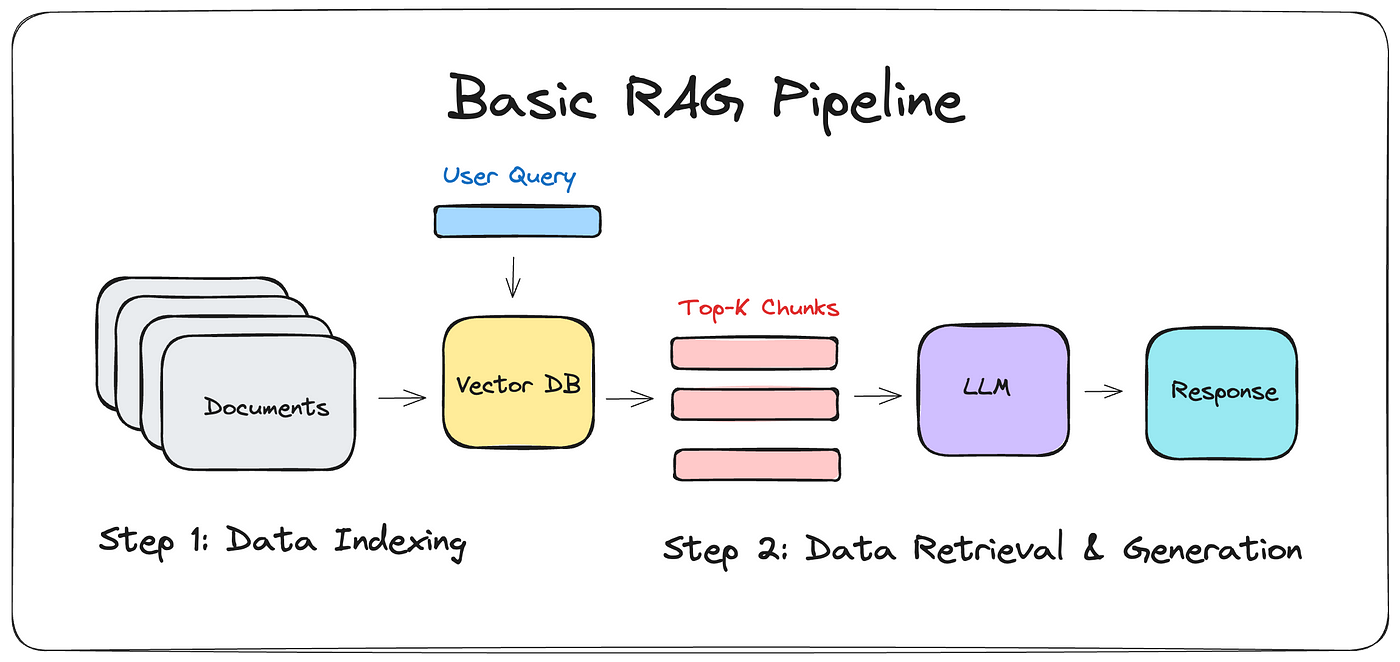

##### How it Works

- User asks a question

- Retriever searches a database or vector store for relevant documents

- LLM reads those retrieved documents

- LLM generates a final answer using both the context and its own knowledge


##### Example Flow in LangGraph

- Node 1: Take the user’s question

- Node 2: Call a retriever tool (e.g., vectorstore.similarity_search())

- Node 3: Pass the retrieved docs + question to the LLM node

- State: Stores both the question and the retrieved documents



In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# Create embedding function
embedding_function = OpenAIEmbeddings()

# Example product and store info documents
docs = [
    Document(
        page_content="TechZone is owned by Priya Sharma, a former engineer who started the store to bring the latest gadgets to her hometown. She has over 15 years of experience in consumer electronics.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="TechZone sells a wide range of products including smartphones, laptops, gaming consoles, and accessories. Smartphone prices start at ₹15,000, laptops range from ₹40,000 to ₹1,20,000, and gaming consoles are priced between ₹35,000 and ₹60,000.",
        metadata={"source": "products.txt"},
    ),
    Document(
        page_content="TechZone is open from Tuesday to Sunday. Weekday hours are 10:00 AM to 8:00 PM, and weekend hours extend to 9:00 PM. The store is closed on Mondays.",
        metadata={"source": "hours.txt"},
    ),
    Document(
        page_content="TechZone offers seasonal discounts during major festivals like Diwali and Christmas. Customers can also sign up for a membership program that gives 10% off on all accessories year-round.",
        metadata={"source": "offers.txt"},
    ),
]

# Create a Chroma vector database
db = Chroma.from_documents(docs, embedding_function)

In [5]:
retriever = db.as_retriever(search_kwargs={"k": 2})

In [6]:
retriever.invoke("Who is owner of techzone?")

[Document(metadata={'source': 'owner.txt'}, page_content='TechZone is owned by Priya Sharma, a former engineer who started the store to bring the latest gadgets to her hometown. She has over 15 years of experience in consumer electronics.'),
 Document(metadata={'source': 'hours.txt'}, page_content='TechZone is open from Tuesday to Sunday. Weekday hours are 10:00 AM to 8:00 PM, and weekend hours extend to 9:00 PM. The store is closed on Mondays.')]

In [7]:
retriever.invoke("What are opening hours?")

[Document(metadata={'source': 'hours.txt'}, page_content='TechZone is open from Tuesday to Sunday. Weekday hours are 10:00 AM to 8:00 PM, and weekend hours extend to 9:00 PM. The store is closed on Mondays.'),
 Document(metadata={'source': 'offers.txt'}, page_content='TechZone offers seasonal discounts during major festivals like Diwali and Christmas. Customers can also sign up for a membership program that gives 10% off on all accessories year-round.')]

### Adding RAG Component

In [8]:
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the question based only on the following context:
{context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [9]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

prompt = hub.pull("rlm/rag-prompt")  # use hub to pull RAG-prompt


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

/Users/g/miniconda3/envs/langgraph/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
qa_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough(),
    }
    | prompt
    | ChatOpenAI()
    | StrOutputParser()
)

In [11]:
qa_chain.invoke("When are the opening hours?")

'TechZone is open from Tuesday to Sunday with weekday hours from 10:00 AM to 8:00 PM and weekend hours until 9:00 PM. The store is closed on Mondays.'

In [12]:
qa_chain.invoke("Who is owner of techzone?")

'Priya Sharma is the owner of TechZone, a store she started to bring the latest gadgets to her hometown. She has over 15 years of experience in consumer electronics.'